# IBM Quantum Experience Lab - Lab script

Please use this notebook as a template for the work that you will submit for assessment for this lab exercise.

Student Names: 

## Warm up exercise

In [126]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, Aer
from qiskit.tools.visualization import circuit_drawer
from qiskit import IBMQ
#This code outputs the version numbers for all  the installed sub-packages of QISKIT. 
# The overall QISKIT version number is displayed about halfway through the list. 
import matplotlib.pyplot as plt
import numpy as np

from qiskit import __qiskit_version__
print(__qiskit_version__)

{'qiskit-terra': '0.16.1', 'qiskit-aer': '0.7.2', 'qiskit-ignis': '0.5.1', 'qiskit-ibmq-provider': '0.11.1', 'qiskit-aqua': '0.8.1', 'qiskit': '0.23.2'}


### Setup the circuit

In [76]:
qr = QuantumRegister(1)
cr = ClassicalRegister(1)
circuit = QuantumCircuit(qr, cr)

circuit.h(qr[0])
circuit.measure(qr[0],cr[0])
circuit_drawer(circuit)

┌───┐┌─┐
q3825_0: ┤ H ├┤M├
         └───┘└╥┘
   c3: 1/══════╩═
               0

In [65]:
backend = Aer.get_backend('qasm_simulator')

In [11]:
def calculate_exp_val(counts):
    """
        Calculate the expectation value given a dictionary of counts
    """
    exp_val = None
    if '1' not in counts:
        exp_val = 1
    elif '0' not in counts:
        exp_val = -1
    else:
        exp_val = (counts['0']-counts['1'])/(counts['0']+counts['1'])
    return exp_val

### Run the circuit
For different values of shots repeated 10 times 

In [68]:
shots_list = [2**n for n in range(1, 20)]
exp_list = []
std_list = []

num_repeat = 10
for shots in shots_list:
    cache = []
    for i in range(num_repeat):
        job = execute(circuit, backend,shots=shots)
        result=job.result()
        counts = result.get_counts(circuit)
        cache.append(calculate_exp_val(counts))
        
    exp_list.append(cache[-1]) 
    # We do not want to average for the graph of expectation
    
    std_list.append(np.std(cache))

### Plot the results
#### Expectations versus shots

Text(0, 0.5, 'expectation')

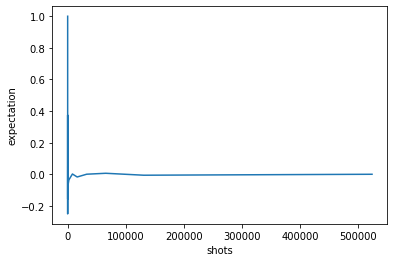

In [69]:
plt.plot(shots_list, exp_list)
plt.xlabel("shots")
plt.ylabel("expectation")

#### Errors versus shots

Text(0, 0.5, 'error')

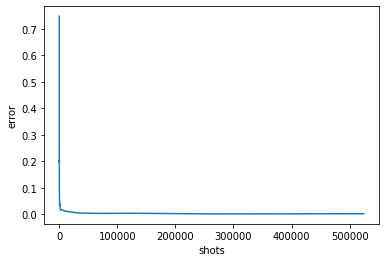

In [73]:
plt.plot(shots_list, std_list)
plt.xlabel("shots")
plt.ylabel("error") 

#### Zoomed version of errors versus shots

Text(0, 0.5, 'error')

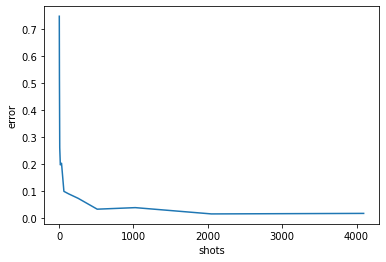

In [80]:
plt.plot(shots_list[:-7], std_list[:-7])
plt.xlabel("shots")
plt.ylabel("error") 

## Main exercises

## Set up circuits

## Method 1 (unitary basis rotation method)
Given that $$M(\theta) = u_1(\theta) X u_1(-\theta)$$ and $H Z H = X$, so 
$$ M(\theta) = u_1(\theta) H Z H u_1(-\theta) $$.
So the change of basis required is $H u_1(-\theta)$.

In [81]:
def circuit_method_1(theta, phi):
    circuit = QuantumCircuit(1, 1)

    # State preparation 
    circuit.h(0)
    circuit.u1(-2*phi, 0)
    circuit.h(0)

    # Change of basis
    circuit.u1(-theta, 0)
    circuit.h(0)
    
    circuit.measure(0, 0)
    
    return circuit

## Method 2 (standard VQE method)
It is given that $$ M(\theta) = \cos (\theta) X + \sin (\theta) Y $$. 
In general we have $$M = \alpha X + \beta Y + \gamma Z + \delta I$$, therefore $$ \alpha = \cos(\theta)$$, $$ \beta = \sin(\theta)$$ and $\gamma = \delta = 0$.

$$ \langle M \rangle = \alpha \langle X \rangle + \beta \langle Y \rangle + \gamma \langle Z \rangle + \delta \langle I \rangle $$ 


In [82]:
def circuit_method_2(theta, phi):
    """
    Since only alpha and beta are non-zero,
    only X and Y expectation values are required.
    """
    
    circuit_X = QuantumCircuit(1, 1)
    circuit_X.h(0)
    circuit_X.u1(-2*phi, 0)
    circuit_X.h(0)

    circuit_X.h(0)
    circuit_X.measure(0, 0)
    
    circuit_Y = QuantumCircuit(1, 1)
    circuit_Y.h(0)
    circuit_Y.u1(-2*phi, 0)
    circuit_Y.h(0)

    circuit_Y.sdg(0)
    circuit_Y.h(0)
    circuit_Y.measure(0, 0)
    
    return circuit_X, circuit_Y


## Calculate exact value of the expectation value 

In [89]:
def true_exp_val(theta, phi):
    M = np.array([[0, np.exp(-1j * theta)],[np.exp(1j* theta), 0]])
    psi = np.array([np.cos(phi), 1j * np.sin(phi)])
    return np.real(psi.T.conj() @ M @ psi)

Specify values for parameters 

In [103]:
pair_1 = (np.pi/4, 0)
pair_2 = (np.pi/8, np.pi/4)
true_val_pair_1 = true_exp_val(*pair_1)
true_val_pair_2 = true_exp_val(*pair_2)
shots = 2**12

Specify backend

In [127]:
from qiskit.providers.ibmq import least_busy
IBMQ.load_account()
IBMQ.providers()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

small_devices = provider.backends(filters=lambda x: x.configuration().n_qubits == 1
                                   and not x.configuration().simulator)
backend=least_busy(small_devices)

print(backend)

/home/kin/miniconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


ibmq_armonk


### Method 1, Pair 1

In [128]:
circuit = circuit_method_1(*pair_1)
job = execute(circuit, backend,shots=shots)
result=job.result()
counts = result.get_counts(circuit)

exp_val_pair_1_method_1 = calculate_exp_val(counts)
err_pair_1_method_1 = abs(exp_val_pair_1_method_1 - true_val_pair_1)

### Method 2, Pair 1

In [129]:
circuit_X, circuit_Y = circuit_method_2(*pair_1)

# Calculate expectation value of Pauli X
job_X = execute(circuit_X, backend,shots=shots/2)
result_X = job_X.result()
counts_X = result_X.get_counts(circuit_X)
exp_val_X = calculate_exp_val(counts_X)

# Calculate expectation value of Pauli Y
job_Y = execute(circuit_Y, backend,shots=shots/2)
result_Y = job_Y.result()
counts_Y = result_Y.get_counts(circuit_Y)
exp_val_Y = calculate_exp_val(counts_Y)

exp_val_pair_1_method_2 = np.cos(theta) * exp_val_X + np.sin(theta) * exp_val_Y
err_pair_1_method_2 = abs(exp_val_pair_1_method_2 - true_val_pair_1)

### Method 1, Pair 2

In [130]:
circuit = circuit_method_1(*pair_2)
job = execute(circuit, backend,shots=shots)
result=job.result()
counts = result.get_counts(circuit)
exp_val_pair_2_method_1 = calculate_exp_val(counts)
err_pair_2_method_1 = abs(exp_val_pair_2_method_1 - true_val_pair_2)

### Method 2, Pair 2

In [131]:
circuit_X, circuit_Y = circuit_method_2(*pair_2)

# Calculate expectation value of Pauli X
job_X = execute(circuit_X, backend,shots=shots/2)
result_X = job_X.result()
counts_X = result_X.get_counts(circuit_X)
exp_val_X = calculate_exp_val(counts_X)

# Calculate expectation value of Pauli Y
job_Y = execute(circuit_Y, backend,shots=shots/2)
result_Y = job_Y.result()
counts_Y = result_Y.get_counts(circuit_Y)
exp_val_Y = calculate_exp_val(counts_Y)

exp_val_pair_2_method_2 = np.cos(theta) * exp_val_X + np.sin(theta) * exp_val_Y
err_pair_2_method_2 = abs(exp_val_pair_2_method_2 - true_val_pair_2)

## Plot errors as bar chart

Text(0, 0.5, 'error in expectation')

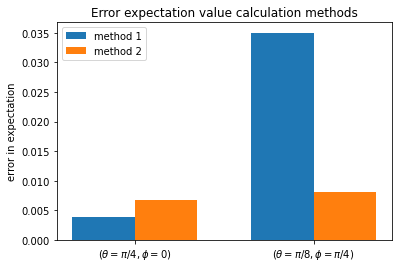

In [132]:
ind = np.array([0, 1])
width = 0.35
plt.bar(ind, [err_pair_1_method_1, err_pair_2_method_1], width, label='method 1')
plt.bar(ind+width, [err_pair_1_method_2, err_pair_2_method_2], width, label='method 2')
plt.legend()

plt.title('Error expectation value calculation methods')
plt.xticks(ind + width / 2, (r'$(\theta = \pi/4, \phi = 0)$', r'$(\theta = \pi/8, \phi = \pi/4)$'))
plt.ylabel('error in expectation')